In [41]:
import numpy    as np
import pandas   as pd
import networkx as nx

import matplotlib.pyplot as plt

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph

In [43]:
df = pd.read_csv("../data/processed/DR16Q_v4_z2.5_sn_25.csv")
df.describe()

,Z,PSFMAG_u,PSFMAG_g,PSFMAG_r,PSFMAG_i,SN_MEDIAN_ALL,u_g,g_r,r_i
count,7377.000000,7377.000000,7377.000000,7377.000000,7377.000000,7377.000000,7377.000000,7377.000000,7377.000000
mean,1.138306,18.150329,17.876695,17.697716,17.567105,32.247842,0.273633,0.178980,0.130610
std,0.670293,0.754149,0.664199,0.619782,0.637297,6.806504,0.256224,0.186571,0.170079
min,0.004153,14.247252,14.388747,14.459476,14.084700,25.002308,-4.715317,-0.500460,-3.427914
25%,0.535000,17.693064,17.472094,17.315643,17.188604,27.175409,0.119520,0.067511,0.011343
50%,1.108355,18.166111,17.925720,17.745609,17.626837,30.111456,0.232590,0.160419,0.110727
75%,1.692241,18.621017,18.310902,18.111753,17.987936,35.441582,0.376476,0.271385,0.228600
max,2.498000,24.634121,25.070984,21.162504,23.304535,76.683449,5.650818,5.194363,1.106255


In [50]:
# 2) Función para quitar tendencia color ~ poly(z)
def residualize_poly(y, z, deg=2):
    z = np.asarray(z); y = np.asarray(y)
    M = np.vstack([z**d for d in range(deg+1)]).T  # [1, z, z^2]
    beta, *_ = np.linalg.lstsq(M, y, rcond=None)
    yhat = M @ beta
    return y - yhat

# 3) Residuales de cada color
for c in ["u_g","g_r","r_i"]:
    df[c+"_res"] = residualize_poly(df[c].values, df["Z"].values, deg=2)

In [51]:
df

,Z,PSFMAG_u,PSFMAG_g,PSFMAG_r,PSFMAG_i,SN_MEDIAN_ALL,u_g,g_r,r_i,u_g_res,g_r_res,r_i_res
0,0.479555,17.988741,17.775442,17.857899,17.800993,28.213453,0.213299,-0.082457,0.056906,-0.041410,-0.257161,-0.085350
1,1.058080,18.752083,18.321392,17.864330,17.908764,45.613338,0.430691,0.457062,-0.044434,0.209955,0.270390,-0.111165
2,1.561726,18.747503,18.418108,18.205875,17.993467,25.194086,0.329395,0.212233,0.212408,0.075699,0.025293,0.130713
3,1.921584,17.882105,17.699511,17.528435,17.254442,34.699078,0.182594,0.171076,0.273993,-0.130307,-0.010266,0.135589
4,0.950000,18.484198,18.286703,18.083042,18.099178,28.562708,0.197495,0.203661,-0.016136,-0.023754,0.018278,-0.089447
...,...,...,...,...,...,...,...,...,...,...,...,...
7372,0.203181,18.221565,18.074781,17.834017,17.426311,35.135700,0.146784,0.240765,0.407705,-0.151265,0.076179,0.194381
7373,0.580000,20.762857,19.494303,18.820398,18.355135,26.930763,1.268555,0.673904,0.465263,1.025254,0.496228,0.343232
7374,0.386000,17.408722,17.270006,17.382782,17.379969,38.882450,0.138716,-0.112776,0.002813,-0.128702,-0.284373,-0.160966
7375,0.690431,17.912672,17.486391,17.531588,17.630966,32.672737,0.426281,-0.045197,-0.099379,0.192851,-0.225707,-0.202624


In [56]:
# 4) Features: colores residualizados (+ i para escala de brillo si quieres)
feat_cols = ["u_g_res","g_r_res","r_i_res"]  # quita PSFMAG_i si prefieres solo colores
X = df[feat_cols].to_numpy()
X = StandardScaler().fit_transform(X)

# 5) k-NN (euclídeo) y simetrización por unión (más conectividad que 'mutual')
k = 10
A = kneighbors_graph(X, n_neighbors=k, mode="distance", metric="minkowski")  # p=2
A = A.maximum(A.T).tocsr()
A.eliminate_zeros()

# 6) Convertir a grafo con pesos de similitud (w = 1/(1+d))
rows, cols = A.nonzero()
w = 1.0 / (1.0 + A.data)
G = nx.Graph()
G.add_weighted_edges_from(zip(rows, cols, w))

# 7) Tomar componente gigante (mejor para layout)
giant_nodes = max(nx.connected_components(G), key=len)
H = G.subgraph(giant_nodes).copy()


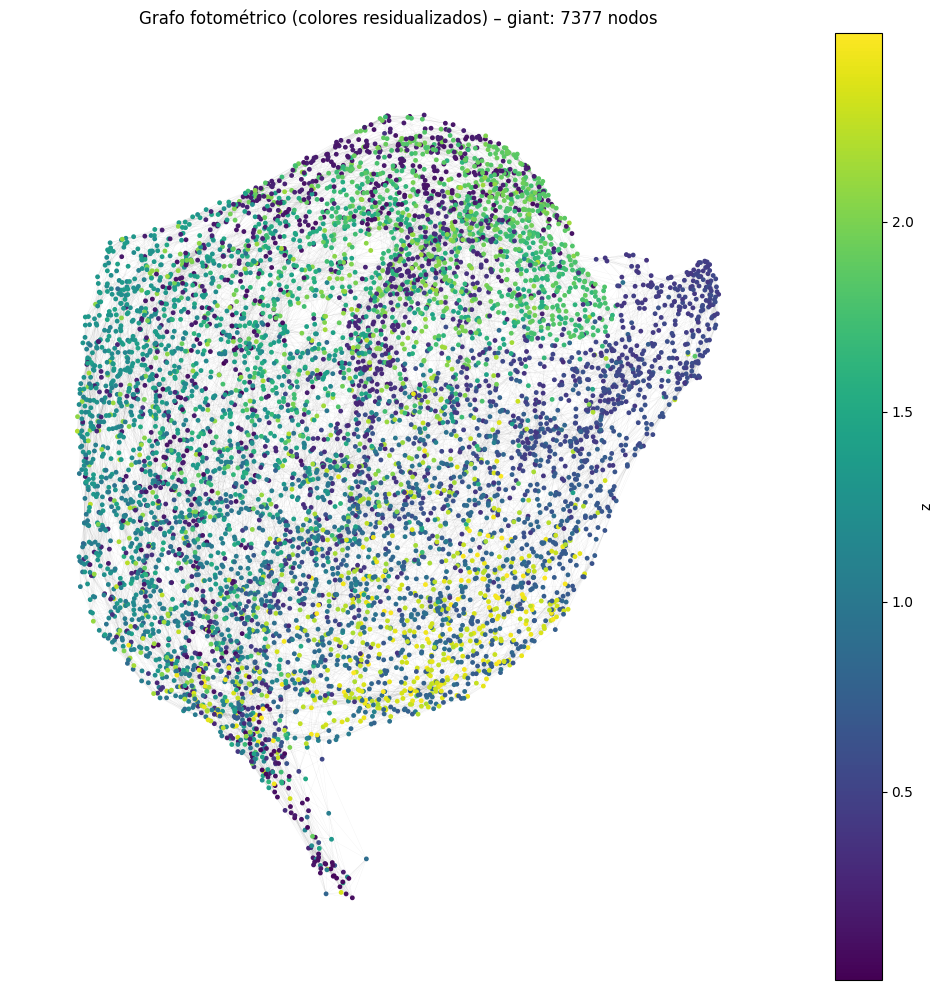

In [57]:
pos = nx.spring_layout(H, seed=42, weight="weight")  # usa pesos (similitudes)
# Colorea por z para chequear que ya no domine (debería verse más “mezclado”)
z = df.loc[list(H.nodes), "Z"].to_numpy()

plt.figure(figsize=(10,10))
nx.draw_networkx_edges(H, pos, alpha=0.06, width=0.25)
sc = nx.draw_networkx_nodes(H, pos, node_size=6, node_color=z, cmap="viridis")
plt.colorbar(sc, label="z")
plt.title(f"Grafo fotométrico (colores residualizados) – giant: {H.number_of_nodes()} nodos")
plt.axis("off"); plt.tight_layout(); plt.show()
